<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-285 - Computación Científica </h1>
    <h2> The numerical issue with the Quadratic Formula</h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 1.06 </h2>
</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/Bonus%20-%20current/Bonus%20-%2002%20-%20Quadratic%20formula.ipynb)

[![Watch on YouTube](https://github.com/tclaudioe/Scientific-Computing-V3/blob/main/images/WatchonYouTube-black-1xPNG.png?raw=true)](https://youtu.be/Igj3PRc_e5A)

<div id='toc' />

## Table of Contents
* [Introduction](#intro)
* [Acknowledgements](#acknowledgements)

In [1]:
##########################
# CoLab requirements
# https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it-within-t
##########################

# https://pypi.org/project/colorama/

import importlib.util
import sys
import subprocess
    
# install_colab_requirements 
libraries = ['numpy', 'scipy', 'matplotlib', 'colorama', 
            'bitstring', 'sympy', 'ipywidgets','pandas']

for library in libraries:
    # Check if the library is already installed
    if importlib.util.find_spec(library) is not None:
        print(f"{library} is already installed.")
    else:
        print(f"{library} is not installed. Installing...")
        # Install the library using pip
        subprocess.check_call([sys.executable, "-m", "pip", "install", library])
        print(f"{library} has been installed.")

numpy is already installed.
scipy is already installed.
matplotlib is already installed.
colorama is already installed.
bitstring is already installed.
sympy is already installed.
ipywidgets is already installed.
pandas is already installed.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
sym.init_printing()
import bitstring as bs
    
from colorama import Fore, Back, Style
# https://pypi.org/project/colorama/
# Fore: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Back: BLACK, RED, GREEN, YELLOW, BLUE, MAGENTA, CYAN, WHITE, RESET.
# Style: DIM, NORMAL, BRIGHT, RESET_ALL
textBold = lambda x: Style.BRIGHT+x+Style.RESET_ALL
textBoldH = lambda x: Style.BRIGHT+Back.YELLOW+x+Style.RESET_ALL
textBoldB = lambda x: Style.BRIGHT+Back.BLUE+Fore.BLACK+x+Style.RESET_ALL
textBoldR = lambda x: Style.BRIGHT+Back.RED+Fore.BLACK+x+Style.RESET_ALL

plt.rcParams.update({
        "text.usetex": True,
        "font.family": "sans-serif",
        "font.sans-serif": "Helvetica",
        "font.size": 18,
    })

In [3]:
# This function shows the bits used for the sign, exponent and mantissa for a 64-bit double precision number.
# Input:
#   f:                  A double precision float number
#   flagMoreReadable:   If True, it will print the number in a more readable format
#   flagPrintNumber:    If True, it will print the number before showing the bits
def to_fps_double(f, flagMoreReadable=False, flagPrintNumber=False):
    if flagPrintNumber:
        print(f'The number is: {f:.16f}', end=' -> ')
    b = bs.pack('>d', f)
    b = b.bin
    sign = b[0]
    exponent = b[1:12]
    mantissa = b[12:]
    if not flagMoreReadable:
        print(sign+' '+exponent+' '+mantissa)
    else:
        exponent_value = int(exponent, 2)-1023
        if exponent_value == -1023: # Special case 00000000000: SubNormal Representation
            print('(',end='')
            if sign == '0':
                print('+0.', end='(')
            else:
                print('-0.', end='(')
            print(mantissa+')_2)* 2^{-1022}')
        else: # Normal Representation
            if exponent_value == 1024: # Special case 111111111111: +-Inf and NaN
                mantissa_value = int(mantissa, 2)
                if mantissa_value == 0:
                    if sign == '0':
                        print('+Inf: ',end='')
                    else:
                        print('-Inf: ',end='')
                else:
                    print('NaN: ',end='')
                print('(',end='')
            # Printing the Normal Representation
            print('(',end='') 
            if sign == '0':
                print('+1.', end='(')
            else:
                print('-1.', end='(')
            print(mantissa+')_2)* 2^{'+str(exponent_value)+'}')

<div id='intro' />

# Introduction
[Back to TOC](#toc)

In this jupyter notebook we will study a classical but useful example to understand the issue with loss of significance.
The example that we will study is the well-known quadratic equation, moreover, its well-known solution formula, i.e. the quadratic formula.
To make sure we are all on the same page, we write down the quadratic equation explicitly:
$$
\begin{equation}
    \widetilde{a}\,x^2+\widetilde{b}\,x+\widetilde{c}=0,
\end{equation}
$$
where $\widetilde{a}\neq 0$, $\widetilde{a}\in\mathbb{R}$, $\widetilde{b}\in\mathbb{R}$, and $\widetilde{c}\in\mathbb{R}$.
For which we all know the quadratic formula solution for $x$, 
$$
\begin{equation}
    x_{\pm} = \dfrac{-\widetilde{b}\pm \sqrt{\widetilde{b}^2-4\,\widetilde{a}\,\widetilde{c}}}{2\,\widetilde{a}}.
\end{equation}
$$
So, you may wonder, what is the problem with this?
And that is the right question!
Thus, before we proceed to fix the issue we actually need to understand the issue.
So, as you may expect, we will proceed to make the quadratic formula to fail in _double precision_.

Just in case you may not believe that the quadractic formula actually provides the values of $x$ as a function of $\widetilde{a}$, $\widetilde{b}$, and $\widetilde{c}$, we will use SymPy to double check on that.

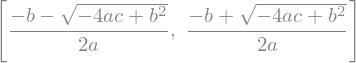

In [4]:
# Defining some symbolic variables. We omit in this case the widetilde used for clarity, but don't forget it!
x,a,b,c = sym.symbols("x,a,b,c")
# Finding the root of the quadratic equation
roots=sym.solve(a*x**2+b*x+c,x)
display(roots)

Therefore, we have sucessfully confirmed that the formula is indeed correct.

The idea os using SymPy is that it can help us to manipulate _complex_ algebraic expressions, for instance, we will reproduce now two classical facts derived from the quadratic formula.
- $x_{-}\,x_{+}$
- $x_{-}+x_{+}$

In [5]:
sym.simplify(roots[0]*roots[1])

In [6]:
sym.simplify(roots[0]+roots[1])

<div id='example' />

# Example for when it works and when it fails the quadratic formula
[Back to TOC](#toc)

For simplicity, we will consider $\widetilde{a}=1$, notice that this can be easily achieved dividing by $\widetilde{a}$ the quadratic equation, of course, the other coefficients will change, but it won't change the nature of the equation.
Recall that we are considering the case when $\widetilde{a}\neq 0$, if $\widetilde{a}$ were equal to $0$, the equation would have been much simpler!
The second simplification is that $c=1$, this may be more tricky to understand, but we invite you to play with different values and experimento what happens!

So, the new equation under study will be:
$$
\begin{equation*}
    x^2+b\,x+1=0,
\end{equation*}
$$
where $b=\dfrac{\widetilde{b}}{\widetilde{a}}$.
For which we all know the quadratic formula solution for $x$, 
$$
\begin{equation*}
    x_{\pm} = \dfrac{-b\pm \sqrt{b^2-4}}{2}.
\end{equation*}
$$
Notice that we used the widetilde ($\widetilde{a}$, $\widetilde{b}$, and $\widetilde{c}$) before so it does not get confused with the notation in this part.

Now, to simplify the problem even further, we will only consider the $+$ solution, i.e. $x_{+}$, this means,
$$
\begin{equation}
    x_{+} = \dfrac{-b+\sqrt{b^2-4}}{2}.
\end{equation}
$$
Also, to avoid handling _complex_ solutions, we will consider $|b|^2 \geq 4$.

First, we will evaluate the solution for several values of $b$, again, for simplicity, $b\geq 2$.

In [7]:
def x_pos(b):
    return (-b+np.sqrt(np.power(b,2)-4.))/2.

for b in np.linspace(2,1000,10):
    print('b=',str(b),', x_pos=',str(x_pos(b)))    

b= 2.0 , x_pos= -1.0
b= 112.88888888888889 , x_pos= -0.008858962924229274
b= 223.77777777777777 , x_pos= -0.004468808208656583
b= 334.66666666666663 , x_pos= -0.0029880744878028054
b= 445.55555555555554 , x_pos= -0.002244400333154317
b= 556.4444444444445 , x_pos= -0.0017971304047819103
b= 667.3333333333333 , x_pos= -0.0014985048633775477
b= 778.2222222222222 , x_pos= -0.0012849821331428757
b= 889.1111111111111 , x_pos= -0.0011247202430695324
b= 1000.0 , x_pos= -0.0010000010000226212


So, as you may notice from before, we don't see any unexpected behavior for now.
The well-known quadratic formula **works just fine**.
We can even plot the outcome and used a vectorized approach.

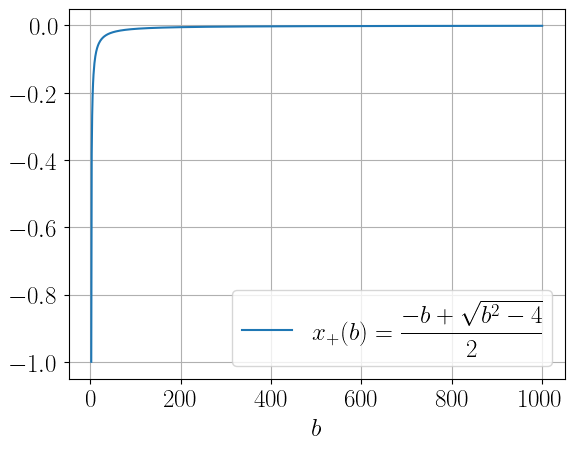

In [8]:
b = np.linspace(2,1000,1000) # Just using a higher resolution for plotting
plt.figure()
plt.plot(b,x_pos(b),'-',label=r'$x_{+}(b)=\displaystyle{\frac{-b+\sqrt{b^2-4}}{2}}$')
plt.grid(True)
plt.xlabel('$b$')
plt.legend(loc='best')
plt.show()

As the plot shows, the solution is negative but tends to $0$ from the negative numbers.
To visualize a bit better we will use a log-scale and plot the absolute value of the solution, since we can't compute the logarithm of negative numbers.

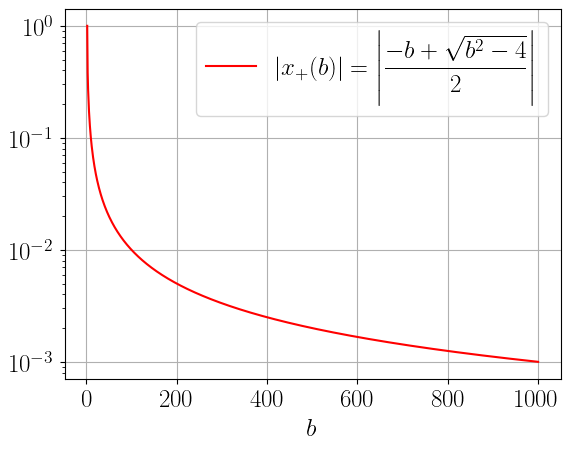

In [9]:
b = np.linspace(2,1000,1000) # Just using a higher resolution for plotting
plt.figure()
plt.semilogy(b,np.abs(x_pos(b)),'r-',label=r'$|x_{+}(b)|=\left|\displaystyle\frac{-b+\sqrt{b^2-4}}{2}\right|$')
plt.grid(True)
plt.xlabel('$b$')
plt.legend(loc='best')
plt.show()

To push it to the limit, we will use a log-log scale, i.e. we will chose $b$ in a log scale, basically to plot large values of $b$.

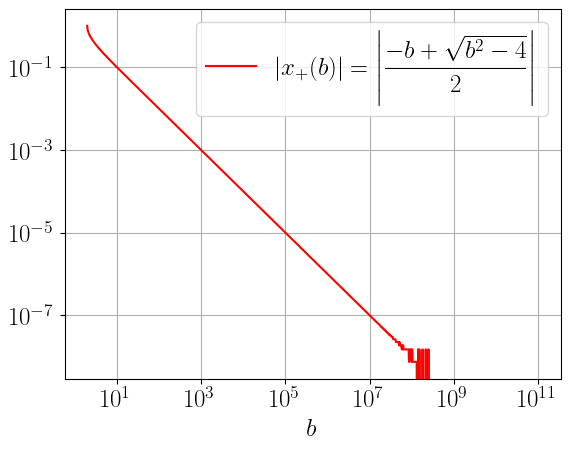

In [10]:
b = np.logspace(np.log10(2),11,1000) # Just using a higher resolution for plotting
plt.figure()
plt.loglog(b,np.abs(x_pos(b)),'r-',label=r'$|x_{+}(b)|=\left|\displaystyle\frac{-b+\sqrt{b^2-4}}{2}\right|$')
plt.grid(True)
plt.xlabel('$b$')
plt.legend(loc='best')
plt.show()

Now, in this plot we observe that the classic quadratic formula behaves well for the values of $b$ in the range $[2,10^7]$ approximately.
And we clearly observe that for values of $b \approx 10^8$ there seems to be a problem.
Even for greater values, the solution does not show up.
**Actually, what it is happening is that for large values, the solution that the quadratic formula computes is $0$, but since we are in log-log scales, it does not show any value because it would be $-\infty$**.
To observe this, we will add a line with the value $10^{-20}$ to be able to see something.

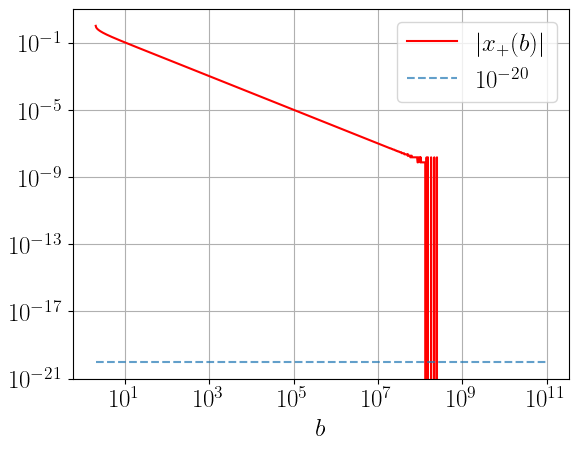

In [11]:
b = np.logspace(np.log10(2),11,1000) # Just using a higher resolution for plotting
plt.figure()
plt.loglog(b,np.abs(x_pos(b)),'r-',label='$|x_{+}(b)|$')
plt.loglog(b,b*0+np.power(10.,-20),'--',label='$10^{-20}$',alpha=0.7)
plt.grid(True)
plt.xlabel('$b$')
plt.legend(loc='best')
plt.show()

What we observe now is that we have confirmed that the outcome was actually $0$.
To confirm this, we will show the bits used by the floating points standard for double precision for $b=10^9$:

In [12]:
to_fps_double(x_pos(b=1.e9))
to_fps_double(x_pos(b=1.e9),True)

0 00000000000 0000000000000000000000000000000000000000000000000000
(+0.(0000000000000000000000000000000000000000000000000000)_2)* 2^{-1022}


The previous outcome proves that the value obtained is actually $0$.

So, the following questions seem critical, 
1. What is happening here?
2. Why is it only happening for large values of $b$?
3. Can this be fixed?

**See next section for the answers**.

# A more detailed analysis

As we have observed numerically, there is an issue with the _direct evaluation of the positive root of the quadratic formula for large values of $b$._
Note that the issue is not always with the positive root, this is just an _toy_ example. The negative root may also show the problem if the same conditions appeared.
For completeness we repeat the formula here:
$$
\begin{equation*}
    x_{+} = \dfrac{-b+\sqrt{b^2-4}}{2}.
\end{equation*}
$$

To answer the first question we will reproduce algebraically what it is happening for the case $b=10^9$:
$$
\begin{align*}
    x_{+}   &= \dfrac{-b+\sqrt{b^2-4}}{2}\\
            &= \dfrac{-10^9+\sqrt{(10^9)^2-4}}{2}\\
            &= \dfrac{-10^9+\sqrt{10^{18}-4}}{2}.
\end{align*}
$$
So, here is the first numercal challenge, can we actually perform the computation of $10^{18}-4$.
To understand this, we will show the floating point representation of each number and the result of the operation.

In [22]:
print(textBoldH("Floating Point representation of the Double Precision (FPDP) of number $10^{18}$"))
to_fps_double(1.e18,True)
print(textBoldH("FPDP of number $4$"))
to_fps_double(4.,True)
print(textBoldH("FPDP of number $10^{18}-4$"))
to_fps_double((1.e18)-4.,True)
print(textBoldH("Just to make sure, we compute $(10^{18}-4)-10^{18}$"))
to_fps_double(((1.e18)-4.)-1.e18,True)
print(textBold("So the outcome is indeed '0', so substracting 4 to 10^18 does not do anything to 10^18"))

Floating Point representation of the Double Precision (FPDP) of number $10^{18}$
(+1.(1011110000010110110101100111010011101100100000000000)_2)* 2^{59}
FPDP of number $4$
(+1.(0000000000000000000000000000000000000000000000000000)_2)* 2^{2}
FPDP of number $10^{18}-4$
(+1.(1011110000010110110101100111010011101100100000000000)_2)* 2^{59}
Just to make sure, we compute $(10^{18}-4)-10^{18}$
(+0.(0000000000000000000000000000000000000000000000000000)_2)* 2^{-1022}
So the outcome is indeed '0', so substracting 4 to 10^18 does not do anything to 10^18


This partially answer the question, now, we need to compute the square root.

In [14]:
print(textBoldH("FPDP of number sqrt{10^{18}}"))
to_fps_double(np.sqrt(1.e18),True)
print(textBoldH("FPDP of number 10^9"))
to_fps_double(1.e9,True)
print(textBoldH("So, the difference between sqrt{10^{18}} and 10^9 is:"))
to_fps_double(np.sqrt(1.e18)-1.e9,True)

FPDP of number sqrt{10^{18}}
(+1.(1101110011010110010100000000000000000000000000000000)_2)* 2^{29}
FPDP of number 10^9
(+1.(1101110011010110010100000000000000000000000000000000)_2)* 2^{29}
So, the difference between sqrt{10^{18}} and 10^9 is:
(+0.(0000000000000000000000000000000000000000000000000000)_2)* 2^{-1022}


What we have observed from the previous numerical experiment is that the $\sqrt{10^{18}}$ is exactly $10^9$, which is indeed the expected result.
**Now, what does this imply?**

Let's put the numerical computation in an algebraic form.
We will be adding $\mathrm{fl}(\cdot)$ where we perform the corresponding numerical computation:
$$
\begin{align*}
    \mathrm{fl}(x_{+})
        &= \dfrac{-10^9+\sqrt{\mathrm{fl}\left(\mathrm{fl}\left(\mathrm{fl}\left(10^{9}\right)^2\right)-4\right)}}{2}\\
        &= \dfrac{-10^9+\sqrt{\mathrm{fl}(10^{18}-4)}}{2}\\
        &= \dfrac{-10^9+\sqrt{\mathrm{fl}(10^{18})}}{2}\\
        &= \dfrac{-10^9+\mathrm{fl}(\sqrt{10^{18}})}{2}\\
        &= \dfrac{\mathrm{fl}(-10^9+10^9)}{2}\\
        &= 0.
\end{align*}
$$

Thus, this analysis answer the first and second questions, which we will repeat here for completeness:
1. What is happening here? **Answer: There is loss of significance.**
2. Why is it only happening for large values of $b$? **Answer: This only happens for large values of $b$ because that is the loss of significance occurs in this case. Particularly, it happens when there is a sum (or substraction) of number that have a difference of more than 16-order of magnitude.**


# Fixing the issue

To answer the third question, we need to think in a way such that we avoid forcing the code to operate between numbers that have a large difference of magnitud in critical steps.
In this case, we can multiply by a convenient $1$ to help us to cancel out the issue.
This means:
$$
\begin{align*}
    x_{+}   &= \dfrac{-b+\sqrt{b^2-4}}{2}\\
            &= \dfrac{-b+\sqrt{b^2-4}}{2} \,\underbrace{\dfrac{(-b-\sqrt{b^2-4})}{(-b-\sqrt{b^2-4})}}_{\displaystyle{\begin{aligned}\text{The convenient $1$}\\\text{for this problem}\end{aligned}}}\\
            &= \dfrac{(-b)^2-(b^2-4)}{2\,(-\,b-\sqrt{b^2-4})}\\
            &= \dfrac{-2}{b+\sqrt{b^2-4}}.
\end{align*}
$$
Notice that in the last step we have conveniently manipulated the mathematical expression simplifying it as much as possible.

Then, **we can implement this new expression now and solve the third question!**

In [15]:
def x_pos_fixed(b):
    return -2./(b+np.sqrt(np.power(b,2)-4.))

Well, you may ask, **is this actually correct?** Let's review if it actually solve the quadratic equation.
For doing this, we will evaluate the polynomial and see if it actually gives us $0$.
We will perform the evaluation with the NumPy routine _np.polyval_ (see the documentation) and we will plot the outcome.
**Notice that to be correct, the residual should be $0$ in exact arithmetic.**

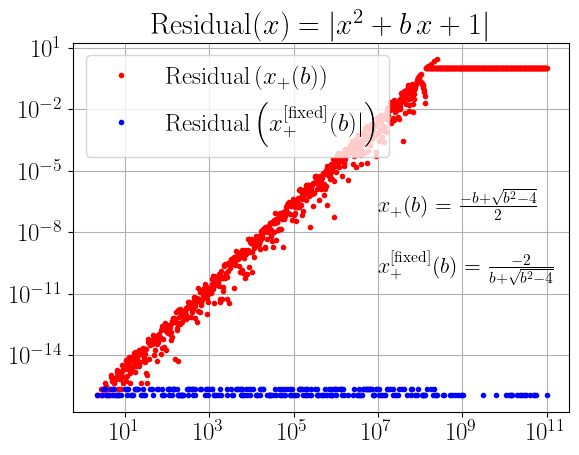

In [16]:
n = 1000
b = np.logspace(np.log10(2),11,n)
outcome_original    = np.zeros(n)
outcome_fixed       = np.zeros(n)
for i, bi in np.ndenumerate(b):
     p                   = np.array([1,bi,1])
     outcome_original[i] = np.polyval(p,x_pos(bi))
     outcome_fixed[i]    = np.polyval(p,x_pos_fixed(bi))
plt.figure()
plt.loglog(b,np.abs(outcome_original),'.r',label=r'$\mathrm{Residual}\left(x_{+}(b)\right)$')
plt.loglog(b,np.abs(outcome_fixed),'.b',label=r'$\mathrm{Residual}\left(x_{+}^{\mathrm{[fixed]}}(b)|\right)$')
plt.title(r'$\mathrm{Residual}(x)=|x^2+b\,x+1|$')
plt.text(1e7, 1e-7, r'$x_{+}(b)=\frac{-b+\sqrt{b^2-4}}{2}$', fontsize=16)
plt.text(1e7, 1e-10, r'$x_{+}^{\mathrm{[fixed]}}(b)=\frac{-2}{b+\sqrt{b^2-4}}$', fontsize=16)
plt.grid(True)
plt.legend(loc='best')
plt.show()

For completeness, we will show the evolution of the root as a function of $b$, the same plot showed few cells back.

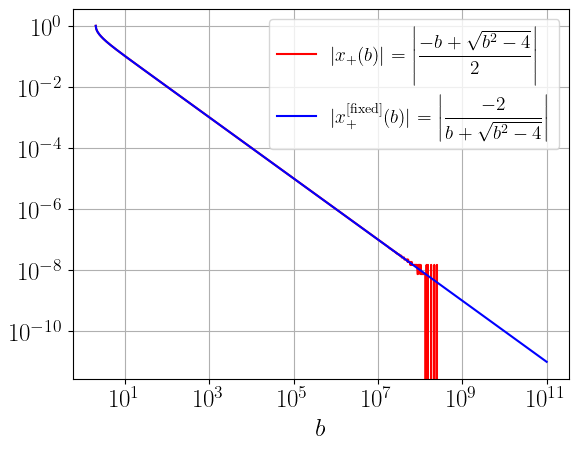

In [17]:
b = np.logspace(np.log10(2),11,1000) # Just using a higher resolution for plotting
plt.figure()
plt.loglog(b,np.abs(x_pos(b)),'r-',label=r'$|x_{+}(b)|=\left|\displaystyle\frac{-b+\sqrt{b^2-4}}{2}\right|$')
plt.loglog(b,np.abs(x_pos_fixed(b)),'b-',label=r'$|x_{+}^{\mathrm{[fixed]}}(b)|=\left|\displaystyle\frac{-2}{b+\sqrt{b^2-4}}\right|$')
plt.grid(True)
plt.xlabel('$b$')
plt.legend(loc='best',fontsize=14)
plt.show()

Here we show the magnitude of the difference between the roots, it show an increasing behaviour that seems to improve later.
This is actually a tricky plot.
First, the scale on the $y$-axis is small.
Second, when it shows a better behaviour is because the fixed root is actually going to zero an the original root is zero (which is wrong).
So please don't get confuse and conclude that thing gets better for the _original solution_ as $b$ increases!
It is actually totally the opposite!
To understand this point, connect this outcome to the previous outcome with the residual.

#### **Challenge: How will this plot change if we perform the computations with _longdouble_ precision?**

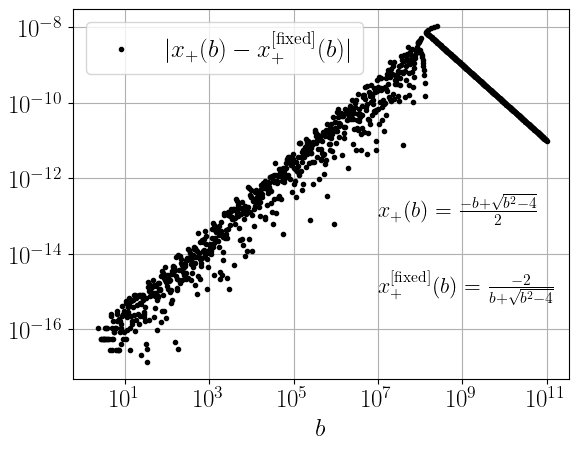

In [18]:
b = np.logspace(np.log10(2),11,1000) # Just using a higher resolution for plotting
plt.figure()
plt.loglog(b,np.abs(x_pos(b)-x_pos_fixed(b)),'.k',label=r'$|x_{+}(b)-x_{+}^{\mathrm{[fixed]}}(b)|$')
plt.grid(True)
plt.xlabel('$b$')
plt.text(1e7, 1e-13, r'$x_{+}(b)=\frac{-b+\sqrt{b^2-4}}{2}$', fontsize=16)
plt.text(1e7, 1e-15, r'$x_{+}^{\mathrm{[fixed]}}(b)=\frac{-2}{b+\sqrt{b^2-4}}$', fontsize=16)
plt.legend(loc='best')
plt.show()

# Conclusion

There is not a general algorithm to solve these kind of problems, they need to by analyzed carefully to point out where you may have an issue.
In particular, a good place to look is when you need to substract numbers, which is actually what happended here, but it is not always the case.
As we say in the other jupyter notebook (using Julia!) to compute $\displaystyle{\sum_{k=1}^\infty} \frac{1}{k^2}$ ([![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tclaudioe/Scientific-Computing-V3/blob/main/Bonus%20-%20current/Bonus%20-%2000%20-%20Playing%20with%20Julia.ipynb)).
**The good news is that you are now aware of the problem and ways to handle it!**



## Quick questions: 
- Will the negative root have a similar problem?
- Can you define a general solver for a quadratic equation that always work?

<div id='acknowledgements' />

# Acknowledgements
[Back to TOC](#toc)

* _Material originally created by professor Claudio Torres_ (`claudio.torres@usm.cl`). v.1.0. DI UTFSM. March 2022._
* _Update March 2023 - v1.01 - C.Torres_ : Removing outdated datatype.
* _Update March 2024 - v1.02 - C.Torres_ : Fixing _typos_ and improving explanation.
* _Update March 2025 - v1.03 - C.Torres_ : Adding Colab link.
* _Update August 2025 - v1.04 - C.Torres_ : Updating the way we install Colab's dependencies, update `to_fps_double` and using LaTeX for all labels in the plots.
* _Update August 2025 - v1.05 - C.Torres_ : Using `display` with SymPy, adding YoutTube link, improving some parts and fixing typos.
* _Update August 2025 - v1.06 - C.Torres_ : Improving even more the explanations and plots in the notebook.

In [19]:
# Extra example, the following code show the log2 of the "machine epsilon" used by Python for the indicated data types. 
# Isn't it interesting? Does not seem to be standard? 
# see: https://numpy.org/doc/stable/user/basics.types.html
print(np.log2(np.finfo(np.float64).eps))
print(np.log2(np.finfo(np.longdouble).eps))

-52.0
-52.0
